In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from kinematic_interpolation import kinematic_interpolation as ki
from typing import List, Tuple, Dict

In [121]:
DATA_PATH = os.path.join('..', 'data')

# load data into pandas dataframe
df = pd.read_csv(os.path.join(DATA_PATH, 'input_scenario_xy.csv'))
df.head()

,t,x,y,vx,vy,speed,heading
0,0.0,484850.605586,4.948439e+06,-0.00000,-0.000000,0.000000,187.0
1,5.0,484850.605586,4.948439e+06,-0.00000,-0.000000,0.000000,187.0
2,8.0,484850.605586,4.948439e+06,-0.00000,-0.000000,0.000000,187.0
3,11.0,484850.443978,4.948437e+06,-0.09945,-0.707622,0.714577,188.0
4,14.0,484849.723516,4.948434e+06,-0.32149,-1.392524,1.429153,193.0


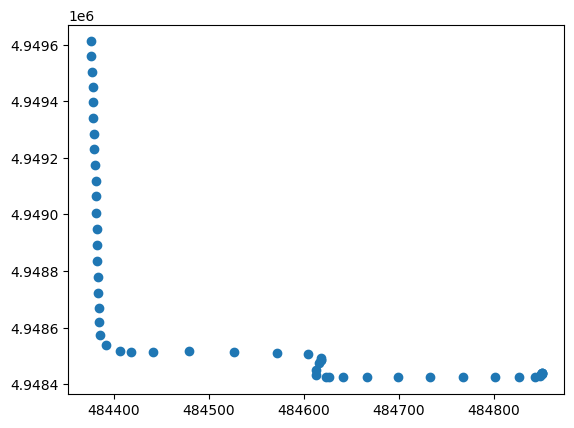

In [116]:
plt.plot(df['x'], df['y'], 'o')

In [122]:
def latlon_to_local_xy(lat: np.ndarray, lon: np.ndarray) -> np.ndarray:
    """
    Convert lat/lon to local ENU coordinates (meters), centered at the first point.
    """
    if len(lat) == 0 or len(lon) == 0:
        raise ValueError("Latitude/Longitude arrays are empty.")
    if len(lat) != len(lon):
        raise ValueError("Latitude and Longitude must have the same length.")
    R = 6371000.0  # Earth radius (m)
    lat0 = np.deg2rad(lat[0])
    lon0 = np.deg2rad(lon[0])
    lat_r = np.deg2rad(lat)
    lon_r = np.deg2rad(lon)
    x = R * (lon_r - lon0) * np.cos(lat0)  # East
    y = R * (lat_r - lat0) # North
    return np.stack([x, y], axis=-1).astype(np.float64)

def detect_noisy_heading(record: Dict[str, list], angle_threshold: float = 30.0) -> np.ndarray:
    """
    Detects noisy heading angles in a trajectory record by comparing the reported heading
    with the direction of movement inferred from consecutive GPS points.

    Args:
        record: A dictionary containing trajectory data with keys 'Latitude', 'Longitude', and 'Heading'.
        angle_threshold: The maximum allowed difference in degrees between the reported heading and
                         the GPS-inferred heading before a point is considered noisy.

    Returns:
        A boolean numpy array where True indicates a noisy heading at that index.
    """
    lat = np.asarray(record.get("Latitude", []), dtype=np.float64)
    lon = np.asarray(record.get("Longitude", []), dtype=np.float64)
    heading = np.asarray(record.get("Heading", []), dtype=np.float64)

    if len(lat) < 2 or len(lon) < 2 or len(heading) < 2:
        # Not enough data to compare headings
        return np.array([False] * len(heading), dtype=bool)

    # Compute GPS-inferred headings between consecutive points
    dxy = latlon_to_local_xy(lat, lon)  # [T, 2]
    movement_vectors = np.diff(dxy, axis=0)  # [T-1, 2]
    movement_angles = np.arctan2(movement_vectors[:, 0], movement_vectors[:, 1])  # radians

    # Convert reported headings to radians
    reported_angles = np.deg2rad(heading[1:])  # skip first point, no movement vector

    # Compute absolute difference in angles, accounting for wrap-around at 2*pi
    angle_diffs = np.abs((movement_angles - reported_angles + np.pi) % (2 * np.pi) - np.pi)
    angle_diffs_deg = np.rad2deg(angle_diffs)
    # Prepend False for the first point (no movement vector)
    noisy = np.concatenate(([False], abs(angle_diffs_deg) > angle_threshold))
    return noisy

def clean_heading(heading_arr: np.ndarray, noisy: np.ndarray) -> np.ndarray:
    heading_rad = np.deg2rad(heading_arr)
    heading_2d = np.stack([np.cos(heading_rad), np.sin(heading_rad)], axis=-1)

    clean_heading_2d = heading_2d.copy()
    for i, is_clean in enumerate(~noisy):
        if is_clean:
            continue
        clean_heading_2d[i] = [np.nan] * 2  # because clean_heading_2d is an array of heading vectors

    # Replace the nans with interpolated values
    nans, x = np.isnan(clean_heading_2d[:,0]), lambda z: z.nonzero()[0]

    if nans.any():
        clean_heading_2d[nans] = np.vstack((np.interp(x(nans), x(~nans), clean_heading_2d[~nans,0]),
                                np.interp(x(nans), x(~nans), clean_heading_2d[~nans,1]))).transpose()
        
    return np.rad2deg(np.arctan2(clean_heading_2d[:,1],clean_heading_2d[:,0]))


def process_traj(record: Dict[str, list]) -> Dict[str, np.ndarray]:
    """
    Process a trajectory record to detect and clean noisy heading angles.

    Args:
        record: A dictionary containing trajectory data with keys 'Latitude', 'Longitude', and 'heading_p'.

    Returns:
        A dictionary with the same keys, where 'heading_p' has been cleaned.
    """
    noisy = detect_noisy_heading(record)
    clean_heading_arr = clean_heading(np.asarray(record.get("Heading", []), dtype=np.float64), noisy)

    # Return a new record with cleaned headings
    return {
        "Latitude": np.asarray(record.get("Latitude", []), dtype=np.float64),
        "Longitude": np.asarray(record.get("Longitude", []), dtype=np.float64),
        "Heading": clean_heading_arr
    }



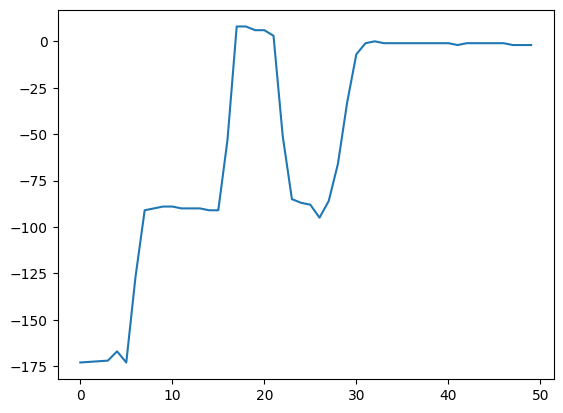

In [123]:
lat, lon = ki.xy_to_latlon(df["x"].to_numpy(), df["y"].to_numpy())
rec = {"Latitude": lat, "Longitude": lon, "Heading": df["heading"].to_numpy()}

processed_traj = process_traj(rec)
lat_p, lon_p, heading_p = processed_traj["Latitude"], processed_traj["Longitude"], processed_traj["Heading"]

plt.plot(heading_p)


In [124]:
df['heading_p'] = heading_p
df['vx_p'] = df['speed'] * np.sin(np.deg2rad(df['heading_p']))
df['vy_p'] = df['speed'] * np.cos(np.deg2rad(df['heading_p']))


In [26]:
# df = df.rename(columns={'time': 't'})
df.to_csv(os.path.join(DATA_PATH, 'input_scenario_raw.csv'), index=False)

In [144]:
import numpy as np
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod


# Constants
EPS = 1e-4
EARTH_RADIUS = 6371000  # in meters

# Define projection for lat/lon to x/y conversion
PROJECTION = pyproj.Proj(proj='utm', zone=15, ellps='WGS84')


def latlon_to_xy(lat, lon):
    """Converts latitude and longitude to Cartesian x, y coordinates."""
    x, y = PROJECTION(lon, lat)
    return x, y

def xy_to_latlon(x, y):
    """Converts Cartesian x, y coordinates back to latitude and longitude."""
    lon, lat = PROJECTION(x, y, inverse=True)
    return lat, lon

def calculate_velocity_components(speed, heading):
    """Calculates velocity components (vx, vy) from speed and heading."""
    radians = np.deg2rad(heading)
    vx = speed * np.sin(radians)
    vy = speed * np.cos(radians)
    return vx, vy

def prepare_data(df):
    """Prepares the dataframe by calculating velocity components and organizing columns."""
    df['vx'], df['vy'] = calculate_velocity_components(df['speed'], df['heading_p'])
    return df[['t', 'x', 'y', 'vx', 'vy', 'speed', 'heading_p']]

def kinematic_position(t, x1, v1, b, c):
    """Computes interpolated position using kinematic equations."""
    return x1 + v1 * t + (t**2) * b / 2 + (t**3) * c / 6

def kinematic_speed(t, v1, b, c):
    """Computes interpolated speed using kinematic equations."""
    return v1 + t * b + (t**2) * c / 2

def kinematic_acceleration(t, b, c):
    """Computes acceleration at a given time using kinematic equations."""
    return b + t * c

# Defining an abstract class for interpolation strategies
class InterpolationStrategy(ABC):
    @abstractmethod
    def interpolate(self, time_from_start, x1, v1, x2, v2, t):
        pass

class LinearAccelerationInterpolation(InterpolationStrategy):
    def interpolate(self, x1, v1, x2, v2, t1, t2, step):
        t = t2 - t1
        times = np.arange(t1, t2, step)
        time_from_start = times - t1
        print(f"Interpolating from t={t1} to t={t2} with step={step}")
        # Solve for coefficients in x-direction
        ax = np.array([[t**2 / 2, t**3 / 6], [t, t**2 / 2]])
        bx = [x2[0] - x1[0] - v1[0] * t, v2[0] - v1[0]]
        coef_x = np.linalg.solve(ax, bx)

        # Solve for coefficients in y-direction
        by = [x2[1] - x1[1] - v1[1] * t, v2[1] - v1[1]]
        coef_y = np.linalg.solve(ax, by)

        # Compute interpolated positions, velocities, and headings
        x = kinematic_position(time_from_start, x1[0], v1[0], coef_x[0], coef_x[1])
        y = kinematic_position(time_from_start, x1[1], v1[1], coef_y[0], coef_y[1])

        vx = kinematic_speed(time_from_start, v1[0], coef_x[0], coef_x[1])
        vy = kinematic_speed(time_from_start, v1[1], coef_y[0], coef_y[1])
        v = np.sqrt(vx**2 + vy**2)

        ax = kinematic_acceleration(time_from_start, coef_x[0], coef_x[1])
        ay = kinematic_acceleration(time_from_start, coef_y[0], coef_y[1])
        a = np.sqrt(ax**2 + ay**2)

        heading = np.arctan2(vx, vy + EPS)
        heading = np.where(heading < 0, heading + 2 * np.pi, heading)
        # print(times)
        return pd.DataFrame({
            'x': x, 'y': y, 't': time_from_start + t1, 'speed': v,
            'acceleration': a, 'heading_p': np.rad2deg(heading)
        })


# TODO: Implement the ConstantAccelerationInterpolation class
class ConstantAccelerationInterpolation(InterpolationStrategy):
    def interpolate(self, time_from_start, x1, v1, x2, v2, t):
        # Implementation for constant acceleration interpolation
        pass


def kinematic_interpolation(segment, time_from_start):
    """Performs kinematic interpolation for a single segment."""
    x1, x2 = segment[0, :2], segment[1, :2]
    t1, t2 = segment[0, 2], segment[1, 2]
    v1, v2 = segment[0, 3:5], segment[1, 3:5]

    t = t2 - t1
    
    # Solve for coefficients in x-direction
    ax = np.array([[t**2 / 2, t**3 / 6], [t, t**2 / 2]])
    bx = [x2[0] - x1[0] - v1[0] * t, v2[0] - v1[0]]
    coef_x = np.linalg.solve(ax, bx)

    # Solve for coefficients in y-direction
    by = [x2[1] - x1[1] - v1[1] * t, v2[1] - v1[1]]
    coef_y = np.linalg.solve(ax, by)

    # Compute interpolated positions, velocities, and headings
    x = kinematic_position(time_from_start, x1[0], v1[0], coef_x[0], coef_x[1])
    y = kinematic_position(time_from_start, x1[1], v1[1], coef_y[0], coef_y[1])

    vx = kinematic_speed(time_from_start, v1[0], coef_x[0], coef_x[1])
    vy = kinematic_speed(time_from_start, v1[1], coef_y[0], coef_y[1])
    v = np.sqrt(vx**2 + vy**2)

    ax = kinematic_acceleration(time_from_start, coef_x[0], coef_x[1])
    ay = kinematic_acceleration(time_from_start, coef_y[0], coef_y[1])
    a = np.sqrt(ax**2 + ay**2)

    heading = np.arctan2(vx, vy + EPS)
    heading = np.where(heading < 0, heading + 2 * np.pi, heading)

    return pd.DataFrame({
        'x': x, 'y': y, 't': time_from_start+ t1, 'speed': v,
        'acceleration': a, 'heading_p': np.rad2deg(heading)
    })

def timestamp_to_seconds(timestamps):
    """Converts timestamps to seconds relative to the first timestamp."""
    timestamps = pd.to_datetime(timestamps)
    start_time = timestamps[0]
    journey_time = [(ts - start_time).total_seconds() for ts in timestamps]
    return journey_time, start_time

def interpolate_trajectory(df, strategy: InterpolationStrategy, step=100):
    """Performs interpolation for the full trajectory using the specified strategy."""
    interpolated_points = pd.DataFrame()
    
    for i in range(len(df) - 1):
        segment = df.iloc[i:i+2][['x', 'y', 't', 'vx', 'vy', 'speed', 'heading_p']].to_numpy()
        t_start = df.iloc[i]['t']
        t_end = df.iloc[i+1]['t']
        
        # Generate multiple intermediate time steps between t_start and t_end
        times = np.arange(t_start, t_end, step)
        # print(times)
        time_from_start= times - t_start

        # interpolated_segment = strategy.interpolate(time_from_start, segment[0, :2], segment[0, 3:5], segment[1, :2], segment[1, 3:5], t_end - t_start)
        interpolated_segment = strategy.interpolate(segment[0, :2], segment[0, 3:5], segment[1, :2], segment[1, 3:5], t_start, t_end, step)
        # print(interpolated_segment)
        interpolated_points = pd.concat([interpolated_points, interpolated_segment], ignore_index=True)

    return interpolated_points

def visualize_results(original_df, interpolated_df):
    """Visualizes the original and interpolated trajectory, speed, heading, and acceleration components."""
    plt.figure(figsize=(10, 6))
    plt.plot(original_df['x'], original_df['y'], 'bo-', alpha = 0.3, label='Original Points')
    plt.scatter(interpolated_df['x'], interpolated_df['y'], c='red', label='Interpolated Points')

    # Add heading arrows for original points
    arrow_scale = 2  # Adjust for visual clarity
    orig_u = np.sin(np.deg2rad(original_df['heading_p'])) * arrow_scale
    orig_v = np.cos(np.deg2rad(original_df['heading_p'])) * arrow_scale
    plt.quiver(original_df['x'], original_df['y'], orig_u, orig_v, color='blue', angles='xy', scale_units='xy', scale=1, width=0.005, label='Original Heading')

    # Add heading arrows for interpolated points
    interp_u = np.sin(np.deg2rad(interpolated_df['heading_p'])) * arrow_scale
    interp_v = np.cos(np.deg2rad(interpolated_df['heading_p'])) * arrow_scale
    plt.quiver(interpolated_df['x'], interpolated_df['y'], interp_u, interp_v, color='red', angles='xy', scale_units='xy', scale=1, width=0.005, label='Interpolated Heading')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Kinematic Interpolation of Trajectory')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(original_df['t'], original_df['speed'], 'bo-', label='Original Speed')
    plt.plot(interpolated_df['t'], interpolated_df['speed'], 'ro-', label='Interpolated Speed')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed')
    plt.title('Speed Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(original_df['t'], original_df['heading_p'], 'bo-', label='Original Heading')
    plt.plot(interpolated_df['t'], interpolated_df['heading_p'], 'ro-', label='Interpolated Heading')
    plt.xlabel('Time (s)')
    plt.ylabel('heading_p')
    plt.title('Heading Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot acceleration magnitude vs time for interpolated points
    plt.figure(figsize=(10, 6))
    if 'acceleration' in original_df.columns:
        plt.plot(original_df['t'], original_df['acceleration'], 'bo-', label='Original Acceleration')
    plt.plot(interpolated_df['t'], interpolated_df['acceleration'], 'ro-', label='Interpolated Acceleration')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration Magnitude')
    plt.title('Acceleration Magnitude Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute acceleration components for original and interpolated data
    def compute_accel_components(df, accel_col, heading_col):
        ax = df[accel_col] * np.sin(np.deg2rad(df[heading_col]))
        ay = df[accel_col] * np.cos(np.deg2rad(df[heading_col]))
        return ax, ay

    # Acceleration X
    plt.figure(figsize=(10, 6))
    if 'acceleration' in original_df.columns:
        ax_orig, _ = compute_accel_components(original_df, 'acceleration', 'heading_p')
        plt.plot(original_df['t'], ax_orig, 'bo-', label='Original Acceleration X')
    ax_interp, _ = compute_accel_components(interpolated_df, 'acceleration', 'heading_p')
    plt.plot(interpolated_df['t'], ax_interp, 'ro-', label='Interpolated Acceleration X')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration X')
    plt.title('Acceleration X Component Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Acceleration Y
    plt.figure(figsize=(10, 6))
    if 'acceleration' in original_df.columns:
        _, ay_orig = compute_accel_components(original_df, 'acceleration', 'heading_p')
        plt.plot(original_df['t'], ay_orig, 'bo-', label='Original Acceleration Y')
    _, ay_interp = compute_accel_components(interpolated_df, 'acceleration', 'heading_p')
    plt.plot(interpolated_df['t'], ay_interp, 'ro-', label='Interpolated Acceleration Y')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration Y')
    plt.title('Acceleration Y Component Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()


In [59]:
result.iloc[:25]

,x,y,t,speed,acceleration,heading_p
0,484850.605586,4.948439e+06,0.0,0.000000,0.000000,0.000000
1,484850.605586,4.948439e+06,1.0,0.000000,0.000000,0.000000
2,484850.605586,4.948439e+06,2.0,0.000000,0.000000,0.000000
3,484850.605586,4.948439e+06,3.0,0.000000,0.000000,0.000000
4,484850.605586,4.948439e+06,4.0,0.000000,0.000000,0.000000
5,484850.605586,4.948439e+06,5.0,0.000000,0.000000,0.000000
6,484850.605586,4.948439e+06,6.0,0.000000,0.000000,0.000000
7,484850.605586,4.948439e+06,7.0,0.000000,0.000000,0.000000
8,484850.605586,4.948439e+06,8.0,0.000000,0.418710,0.000000
9,484850.585788,4.948439e+06,9.0,0.358486,0.298304,186.195261


In [78]:
bx, mx = np.linalg.solve([[4.5, 4.5],[3, 4.5]], [-4.1718, -4.705])
by, my = np.linalg.solve([[4.5, 4.5],[3, 4.5]], [5.227, -0.3217])

In [86]:
by, my

(np.float64(3.6991333333333327), np.float64(-2.5375777777777775))

In [85]:
vx1 = df.iloc[5]['vx'] + bx + mx/2
vy1 = df.iloc[5]['vy'] + by + my/2

vx2 = df.iloc[5]['vx'] + bx*2 + (mx*(2)**2)/2
vy2 = df.iloc[5]['vy'] + by*2 + (my*(2)**2)/2

vx3 = df.iloc[5]['vx'] + bx*3 + (mx*(3)**2)/2
vy3 = df.iloc[5]['vy'] + by*3 + (my*(3)**2)/2

vx1,  vx2,  vx3, vy1, vy2, vy3

(np.float64(-0.7219822013733319),
 np.float64(-2.2903155347066653),
 np.float64(-5.141182201373332),
 np.float64(-1.1220745092565572),
 np.float64(-1.2293078425898907),
 np.float64(-3.874118953701001))

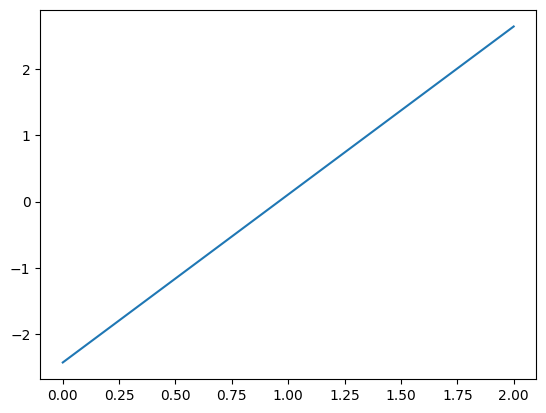

In [92]:
ax0 = df.iloc[5]['vx'] - vx1
ax1 = vx1 - vx2
ax2 = vx2 - vx3


ay0 = df.iloc[5]['vy'] - vy1
ay1 = vy1 - vy2
ay2 = vy2 - vy3

plt.plot([ay0, ay1, ay2])

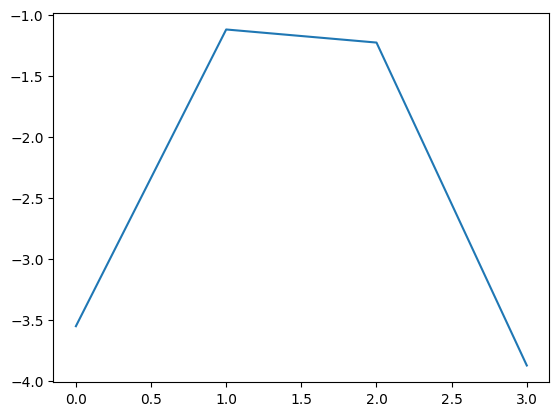

In [88]:
plt.plot([df.iloc[5]['vy'], vy1,  vy2,  vy3])

In [84]:
np.sqrt(vx1**2 + vy1**2), np.sqrt(vx2**2 + vy2**2), np.sqrt(vx3**2 + vy3**2)    

(np.float64(1.334282392682758),
 np.float64(2.599373582302415),
 np.float64(6.437433657533356))

In [114]:
t2 = 7
t1 = 6
vx2 = df.iloc[t2]['vx']
vy2 = df.iloc[t2]['vy']
vx1 = df.iloc[t1]['vx']
vy1 = df.iloc[t1]['vy']

x1 = df.iloc[t1]['x']
y1 = df.iloc[t1]['y']
x2 = df.iloc[t2]['x']
y2 = df.iloc[t2]['y']

by, my = np.linalg.solve([[3**2/2, 3**3/6],[3, 3**2/2]], [y2 - y1 - vy1*3, vy2 - vy1])
bx, mx = np.linalg.solve([[3**2/2, 3**3/6],[3, 3**2/2]], [x2 - x1 - vx1*3, vx2 - vx1])

vx_1 = vx1 + bx + mx/2
vx_2 = vx1 + bx*2 + (mx*(2)**2)/2
vx_3 = vx1 + bx*3 + (mx*(3)**2)/2

vy_1 = vy1 + by + my/2
vy_2 = vy1 + by*2 + (my*(2)**2)/2
vy_3 = vy1 + by*3 + (my*(3)**2)/2

vx1, vx_1, vx_2, vx_3, vy1, vy_1, vy_2, vy_3

(np.float64(-5.141138628284973),
 np.float64(-3.209223269586617),
 np.float64(-5.788529779579419),
 np.float64(-12.87905815826338),
 np.float64(-3.874125835484065),
 np.float64(-0.25303017552068274),
 np.float64(0.9634101708517466),
 np.float64(-0.22480479636677586))

In [113]:
df

,t,x,y,vx,vy,speed,heading
0,0.0,484850.605586,4.948439e+06,-0.000000,-0.000000e+00,0.000000,187.0
1,5.0,484850.605586,4.948439e+06,-0.000000,-0.000000e+00,0.000000,187.0
2,8.0,484850.605586,4.948439e+06,-0.000000,-0.000000e+00,0.000000,187.0
3,11.0,484850.443978,4.948437e+06,-0.099450,-7.076224e-01,0.714577,188.0
4,14.0,484849.723516,4.948434e+06,-0.321490,-1.392524e+00,1.429153,193.0
5,17.0,484848.999404,4.948430e+06,-0.436182,-3.552419e+00,3.579097,187.0
6,20.0,484843.519038,4.948424e+06,-5.141139,-3.874126e+00,6.437403,233.0
7,23.0,484826.638992,4.948423e+06,-12.879058,-2.248048e-01,12.881020,269.0
8,26.0,484801.124606,4.948424e+06,-19.324638,-3.549878e-15,19.324638,270.0
9,29.0,484767.607199,4.948425e+06,-25.049861,4.372470e-01,25.053677,271.0


In [94]:
result.iloc[:20]

,x,y,t,speed,acceleration,heading_p
0,484850.605586,4.948439e+06,0.0,0.000000,0.000000,0.000000
1,484850.605586,4.948439e+06,1.0,0.000000,0.000000,0.000000
2,484850.605586,4.948439e+06,2.0,0.000000,0.000000,0.000000
3,484850.605586,4.948439e+06,3.0,0.000000,0.000000,0.000000
4,484850.605586,4.948439e+06,4.0,0.000000,0.000000,0.000000
5,484850.605586,4.948439e+06,5.0,0.000000,0.000000,0.000000
6,484850.605586,4.948439e+06,6.0,0.000000,0.000000,0.000000
7,484850.605586,4.948439e+06,7.0,0.000000,0.000000,0.000000
8,484850.605586,4.948439e+06,8.0,0.000000,0.418710,0.000000
9,484850.585788,4.948439e+06,9.0,0.358486,0.298304,186.195261


In [146]:
df = pd.read_csv('./../data/sample.csv')
df.rename(columns={'Unnamed: 0': 't', 'heading': 'heading_p'}, inplace=True)

In [147]:
df['speed'] = (df['vx']**2 + df['vy']**2)**0.5

In [142]:
df

,t,vx,vy,heading_p,x,y,ax,ay,speed
0,0,0.0,0.0,91.000000,0.00,0.000,0.0,0.0,0.0
1,1,0.0,0.0,90.990099,0.00,0.000,0.0,0.0,0.0
2,2,0.0,0.0,90.980199,0.00,0.000,0.0,0.0,0.0
3,3,0.0,0.0,90.970298,0.00,0.000,0.0,0.0,0.0
4,4,0.0,0.0,90.960398,0.00,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3056,3056,0.0,0.0,-4.000000,-35955.41,13823.744,0.0,0.0,0.0
3057,3057,0.0,0.0,-4.000000,-35955.41,13823.744,0.0,0.0,0.0
3058,3058,0.0,0.0,-4.000000,-35955.41,13823.744,0.0,0.0,0.0
3059,3059,0.0,0.0,-5.500000,-35955.41,13823.744,0.0,0.0,0.0


Interpolating from t=0.0 to t=1.0 with step=1
Interpolating from t=1.0 to t=2.0 with step=1
Interpolating from t=2.0 to t=3.0 with step=1
Interpolating from t=3.0 to t=4.0 with step=1
Interpolating from t=4.0 to t=5.0 with step=1
Interpolating from t=5.0 to t=6.0 with step=1
Interpolating from t=6.0 to t=7.0 with step=1
Interpolating from t=7.0 to t=8.0 with step=1
Interpolating from t=8.0 to t=9.0 with step=1
Interpolating from t=9.0 to t=10.0 with step=1
Interpolating from t=10.0 to t=11.0 with step=1
Interpolating from t=11.0 to t=12.0 with step=1
Interpolating from t=12.0 to t=13.0 with step=1
Interpolating from t=13.0 to t=14.0 with step=1
Interpolating from t=14.0 to t=15.0 with step=1
Interpolating from t=15.0 to t=16.0 with step=1
Interpolating from t=16.0 to t=17.0 with step=1
Interpolating from t=17.0 to t=18.0 with step=1
Interpolating from t=18.0 to t=19.0 with step=1
Interpolating from t=19.0 to t=20.0 with step=1
Interpolating from t=20.0 to t=21.0 with step=1
Interpolati

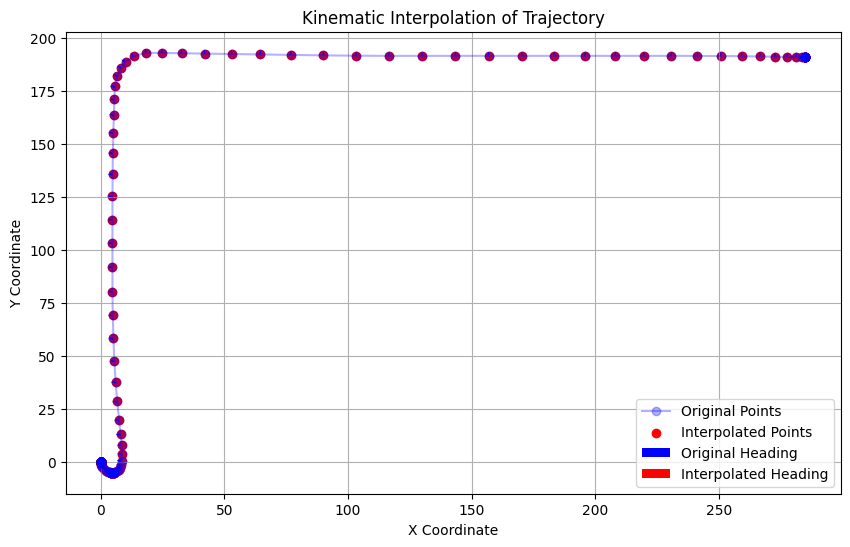

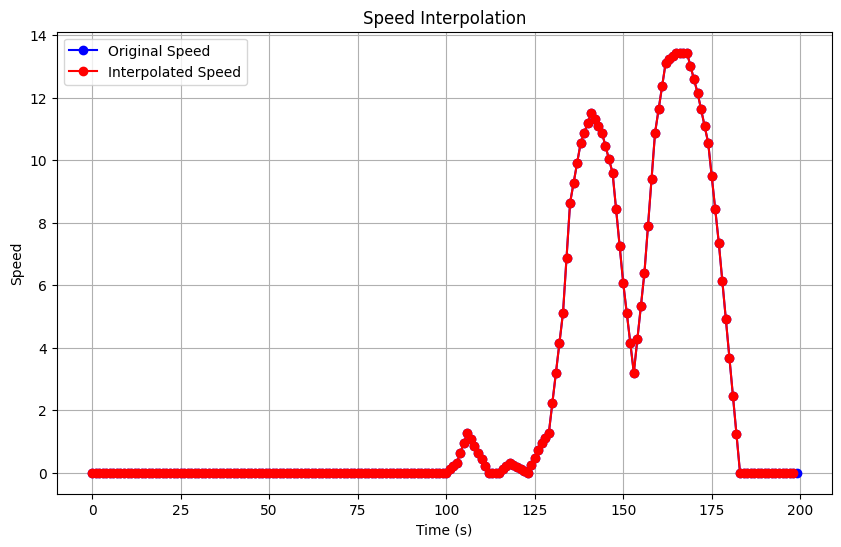

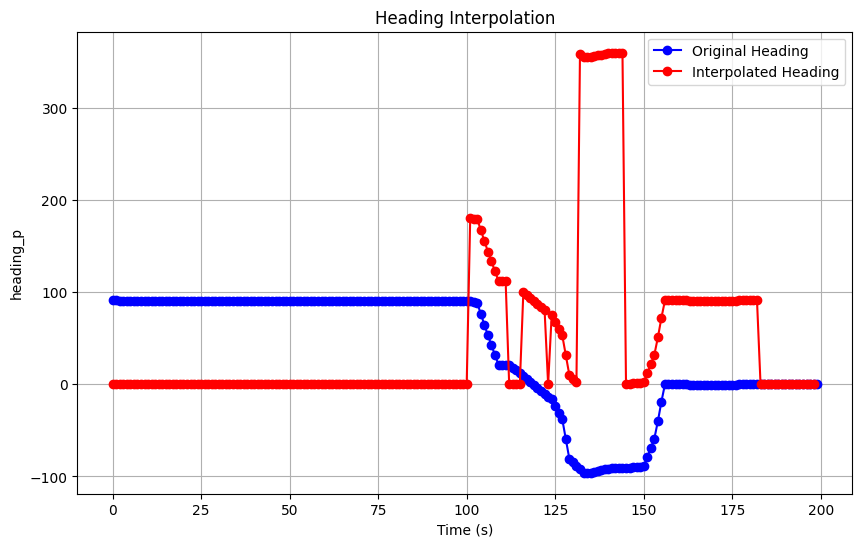

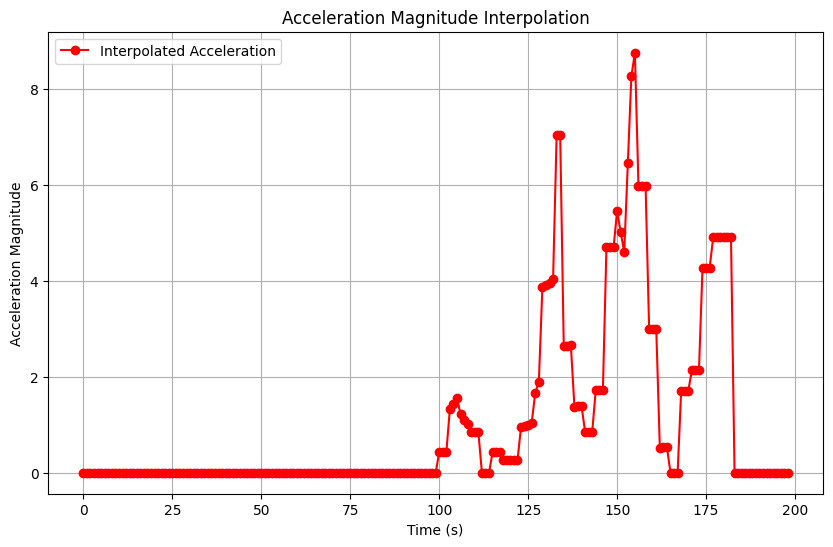

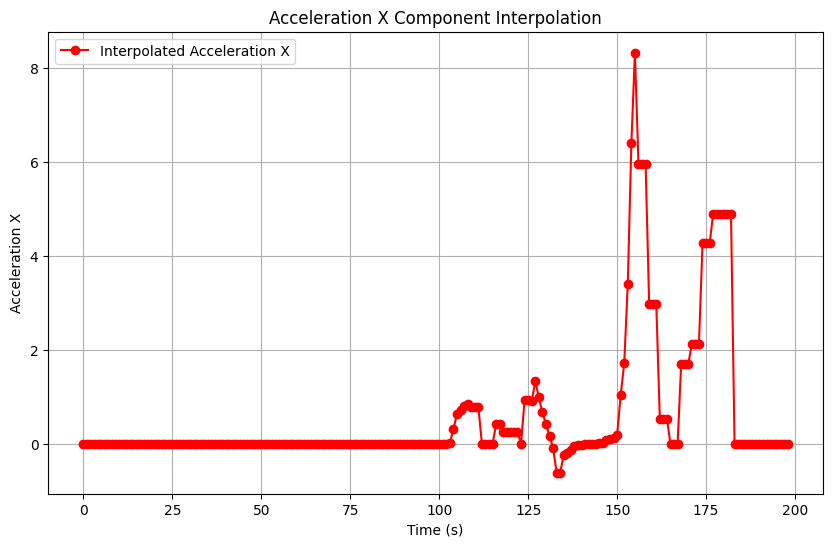

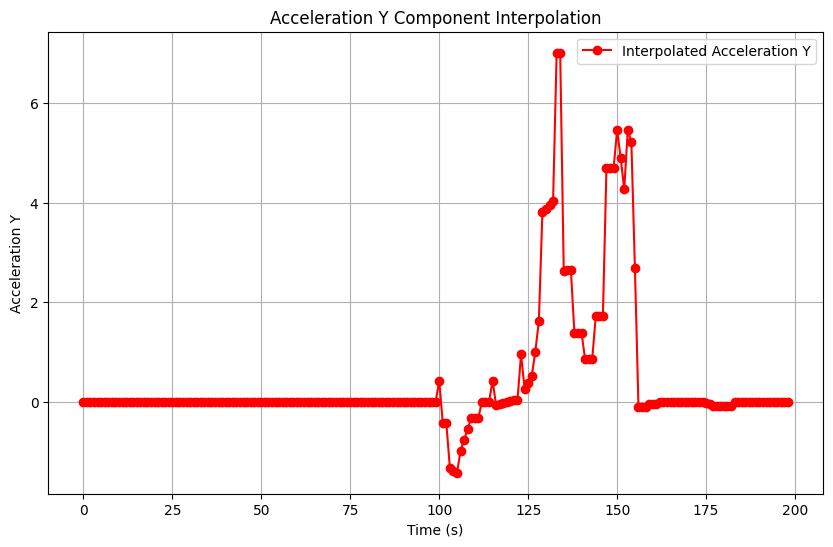

In [148]:
# Prepare data by calculating velocity components
# df = prepare_data(df)
df_ = df.iloc[:200]
strategy = LinearAccelerationInterpolation()
num_interpolations = 1  # Adjust this value as needed
result = interpolate_trajectory(df_, strategy, num_interpolations)
visualize_results(df_, result)
# # Perform full interpolation on the trajectory
# interpolated_points = ki.interpolate_trajectory(df)

# # Convert interpolated x/y back to lat/lon
# interpolated_latlon = [ki.xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
# interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# # Visualize the results
# ki.visualize_results(df, interpolated_points)


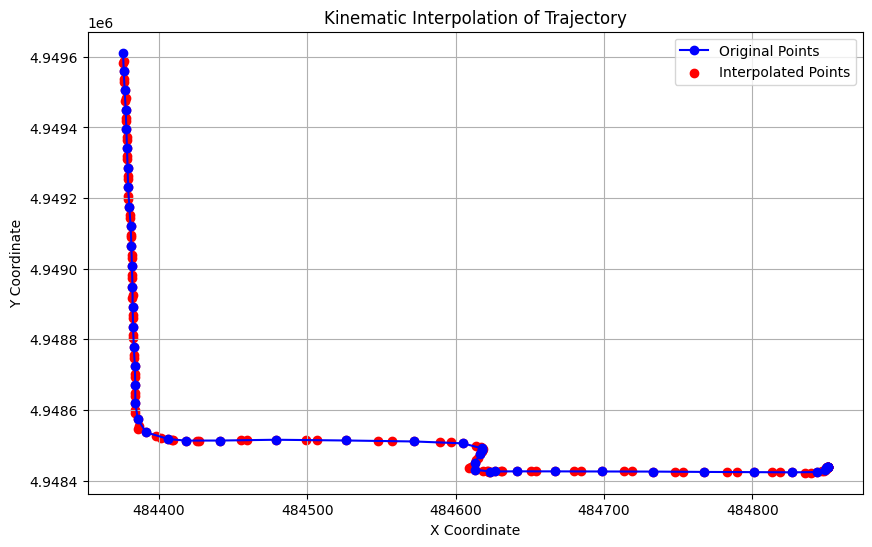

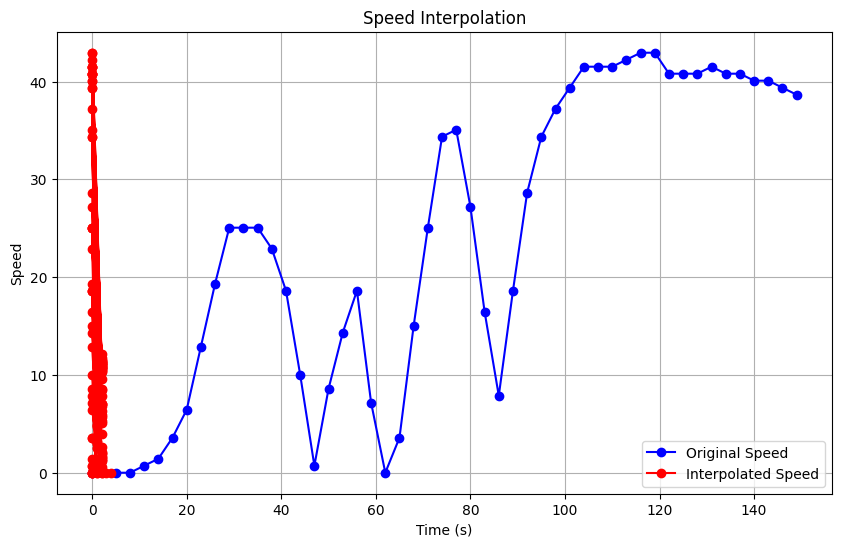

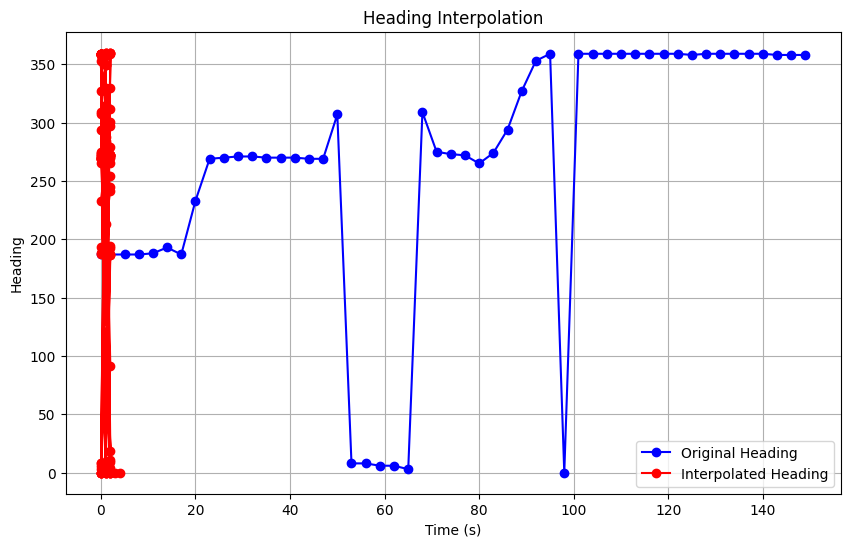

In [8]:
# Prepare data by calculating velocity components
df = prepare_data(df)
strategy = LinearAccelerationInterpolation()
num_interpolations = 1  # Adjust this value as needed
result = interpolate_trajectory(df, strategy, num_interpolations)
visualize_results(df, result)
# # Perform full interpolation on the trajectory
# interpolated_points = ki.interpolate_trajectory(df)

# # Convert interpolated x/y back to lat/lon
# interpolated_latlon = [ki.xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
# interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# # Visualize the results
# ki.visualize_results(df, interpolated_points)


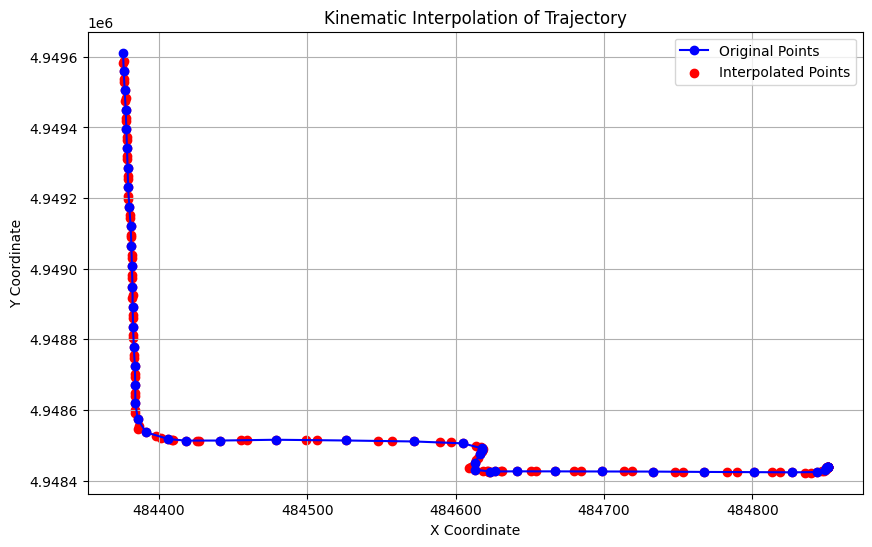

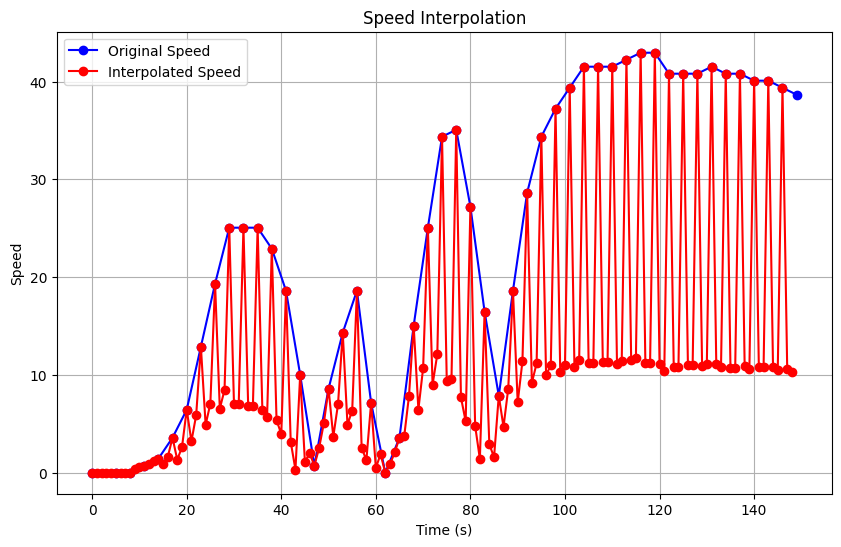

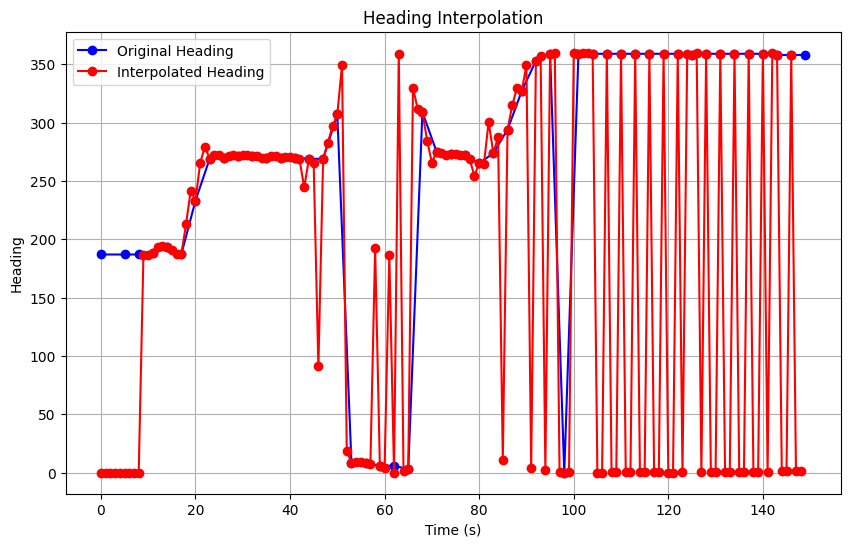

In [10]:
# Prepare data by calculating velocity components
df = prepare_data(df)

# Perform full interpolation on the trajectory
interpolated_points = interpolate_trajectory(df)

# Convert interpolated x/y back to lat/lon
interpolated_latlon = [xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# Visualize the results
ki.visualize_results(df, interpolated_points)


In [7]:
# Prepare data by calculating velocity components
df = ki.prepare_data(df)

# Perform full interpolation on the trajectory
interpolated_points = ki.interpolate_trajectory(df)

# Convert interpolated x/y back to lat/lon
interpolated_latlon = [ki.xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# Visualize the results
ki.visualize_results(df, interpolated_points)


TypeError: interpolate_trajectory() missing 1 required positional argument: 'strategy'